# Learning Curve and Model Score Estimation
TODO: expand to: Emperical study of model score estimation.

The [King County Housing Data](https://www.kaggle.com/harlfoxem/housesalesprediction/data) from Kaggle will be used.  The model will predict house price.

The Learning Curve for a particular model, is the model's score vs amount of data.  More data allows for a better trained model which allows for a higher score (or lower error).

The Learning Curve can also be used to determine how much data is necessary to train on.  Once the curve flattens out, additional data is no longer necessary.

In the following, RMSE of the predicted price vs the actual price will be computed.  Scikit Learn has 'neg_mean_squared_error', but RMSE is more natural and it is easy to create a custom scorer.

Scikit Learn maximizes based on the scorer.  If the scorer is a measure of error, such as RMSE or MSE, then the negative of the value needs to be used so that error is minimized.

The Learning Curve is created by estimating the model's score.  The most often used "estimator" of model score is K-Fold Cross Validation, but other model score estimators are possible.

The model score estimator itself has bias and variance.  This can be seen in the learning curve.

This notebook will create a Learning Curve and will examine the bias and variance of model score estimators. 

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

### Prior Notebook Setup
As per [Cross Validation: W and W/O cross_val_score](http://nbviewer.jupyter.org/github/sdiehl28/tutorial-jupyter-notebooks/blob/master/projects/king_county/CV_Pipeline.ipynb)

In [2]:
# read king county housing data
parser = lambda date: pd.datetime.strptime(date, '%Y%m%dT%H%M%S')
all_data = pd.read_csv('./data/kc_house_data.csv', parse_dates=['date'], date_parser=parser)

# compute mean sales price per house
mean_price_by_id = all_data.groupby(['id'])['price'].mean()

# convert this to a data frame
mean_price_by_id = pd.DataFrame(mean_price_by_id).reset_index()

# join on id to get a new column for mean price
all_data = all_data.merge(right=mean_price_by_id, on='id', suffixes=['_orig', '_mean'])

# drop original price and de-dup the records
all_data = all_data.drop('price_orig', axis=1).drop_duplicates(subset='id')

# remove id and date fields
all_data = all_data.drop(['id', 'date'], axis=1)

# repace yr_built with yr_renovated if yr_renovated != 0
mask = all_data['yr_renovated'] != 0
all_data.loc[mask, 'yr_built'] = all_data.loc[mask, 'yr_renovated']
all_data = all_data.drop('yr_renovated',axis=1)

all_data = all_data.drop(['zipcode'], axis=1)

X_all = all_data.drop('price_mean', axis=1)
y_all = all_data['price_mean']
print(X_all.shape)
print(y_all.shape)

(21436, 16)
(21436,)


## Learning Curve
The full King County Housing dataset consists of 21613 records.  We can simulate having less observations, from the same distribution, by taking a random subsample of these records.  In the following the size of the sample varies from 10% to 100% of the total number of records.

A given random sample of data may be unrepresentative of the data as a whole. This sample variance leads to differences in model score estimations.  To reduce the sample variance, each random sample will be chosen 10 times from the original King County dataset and the average K-Fold CV scores will be used.  Note that this is not the same thing as Repeated K-Fold CV.  Repeated K-Fold CV uses the *same* sample, and makes repeated K-Fold CV model score estimates using different train/test splits.  Repeated K-Fold CV cannot account for sample variance, but it can account, to some extent, for the inherent variance in the K-Fold CV estimation itself.

With the subsample is 100% of the original data, there is only one way to chose the data.  For this case, the code below does amount to Repeated K-Fold CV.

Repeated K-Fold CV has been shown to reduce the variance of the model score's estimate, but it does not cause the bias to approach zero. The modern (2018) recommendation appears to be to use 1 to 20 iterations of K-Fold CV and to consider the variance implied by repeated K-Fold CV as being too small.  That is, the true value of the model's score may be more than 2 standard deviations away from the point-estimate, more than 5% of the time, when using Repeated K-Fold CV.

TODO: cite references for previous paragraph

### More Data
As the amount of data goes up, the RMSE and the standard deviation of RMSE will go down.

### Higher K in K-Fold CV
For a given amount of data, as K goes up, there is more data available for training and hence the bias of the model's score does down.  However there is less data available for validation and hence the variance of the model's score goes up. In what follows, K will be varied to observe these relationships.

The flatter the learning curve is, the less affect K will have on the estimate of the model's score.

### Model Score Estimation is Not Model Creation
The purpose of CV is to provide an estimate of how well a specific model will do on out-of-sample data.  

The estimate of the model's performance can be used for:
* Model Selection
* Model Estimation

In model selection, we use the estimate of the model's score to chose the best model (or the best hyperparameters). In most cases, the bais in the estimate of the model's score is similar for the models being considered.  As such, this bias does not impact the selection of which model is best.

In mode estimation, we use the estimate of the model's score to estimate how well the model will do when deployed.

A common misunderstanding is that CV is used to create or improve a specific model.  This is not correct.  In particular, no model created during the CV process is used for model deployment.  The model that is created for deployment is trained on the entire dataset (unless the learning curve shows that using all the data is unnecessary).

GridSeachCV() and RandomSearchCV() appear to use CV to create the best model, but actually there is a default parameter of "refit=True", which invokes a final step of refitting the model using all available data to the best hyperparameters found. In this case too, no model created during CV is returned to the user.

As can be seen from the Learning Curve, CV provides a pessimistic estimate of the model's performance.  CV uses less than the full amount of data to train with, and if the learning curve is steep, then this impacts the CV estimate of the model's score significantly.  If the Learning Curve is flat, then CV will not have a pessimistic bias of the model's performance.

It is not always best to pick the model with the best score.  If the estimate of the best score has high variance, then the selected model might not really be best.  ESL recommends the one sigma rule, which is to pick the simplest model that is within one standard deviation of the best model.  Ideas such as this will be explored in greater detail in the notebook on Model Selection and Bias Correction.

TODO: Link to ESL (and ISL if the above is stated there).

All of the above is graphically demonstrated below. 

### Imports

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error
from time import time

### Dask
Dask offers at least two advantages:
* ability to work with problems that do not fit in a single computer's memory
* distributed processing across computers (and excellent use of all cores on a single computer)

Below, Dask is use for distributed processing in order to speed up the computations.

Scikit Learn has built-in multiprocessing support for at least the following:
* cross_val_score()
* GridSearchCV()
* RandomSearchCV()

This can be enabled by setting n_jobs=-1, for example.

In my performance tests, using Dask improved performance even on a single computer.  Using Dask for distributed computing across two computers offered a major performance improvement.

If you are using more than one computer, you should ensure that your Anaconda environment is identical on all computers.

My setup consists of two desktop computers:
* Intel Xeon E5-1630v3 3.70GHz -- 4 physical cores with hyperthreading
* Intel Core I7-7700 3.60GHz -- 4 physical cores with hyperthreading

In [4]:
# Dask Setup
# import joblib

from dask.distributed import Client
try:
    client.close()
except:
    print('client was not open')
client = Client('atlantis:8786')
client

client was not open


/home/agni/anaconda3/envs/ml/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/agni/anaconda3/envs/ml/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Client Scheduler: tcp://atlantis:8786 Dashboard: http://atlantis:8787/status,Cluster Workers: 2 Cores: 16 Memory: 134.89 GB


### Compute Learning Curve
10 different realizations each of 10 different sized subsets of the data will be used.  K will be varied to see the effect of K on model score estimation.

In [5]:
# Create custom scorer for RMSE
from sklearn.metrics import make_scorer

def my_rmse_scorer(y, y_pred):
    
    # use numpy vectorized arthimetic
    return -np.sqrt(np.mean((y-y_pred)*(y-y_pred)))

rmse_scorer = make_scorer(my_rmse_scorer)

In [6]:
# Create random subsample
def get_random_subsample(X, y, frac, random_state=None):
    ''' 
    X is a 2D numpy array of numeric features
    y is a 1D numpy array of numeric target values
    frac is the percentage of the sample to take
    returns a subsample of X, y as a tuple
    '''
    
    # affects numpy.random.choice
    if random_state:
        np.random.seed(random_state)
    
    # select a random sample of frac size
    n_records = X.shape[0]
    n = int(frac*n_records)
    idx = np.random.choice(n_records, size=n, replace=False)
    X = X[idx, :]
    y = y[idx]
    
    return (X, y)

In [7]:
# define a specific model
def create_model():
    # The hyperparameters used here were determined in the CV_Hyperparameter notebook
    scale = StandardScaler()
    pca = PCA(n_components=8)
    knn = KNeighborsRegressor(n_neighbors=10, weights='distance')

    return Pipeline(steps=[('scale', scale),('pca',pca), ('knn',knn)])

In [8]:
# Learning Curve4
def learning_curve4(classifier, X_s, y_s, k_fold, n_repeats, random_state=None):
        
    # print(f'RandomState: {random_state} frac: {frac:3.1f} k_fold {k_fold}')

    cv = RepeatedKFold(n_splits=k_fold, n_repeats=n_repeats, random_state=random_state+9)

    # compute the K cross validated scores
    # use n_jobs = 1 as this entire function will be parallelized
    scores = cross_val_score(classifier, X_s, y_s, cv=cv, n_jobs=1, scoring = rmse_scorer)

    return pd.DataFrame(data=[[k_fold, X_s.shape[0], random_state, scores.mean(), scores.std()]], 
                            columns=['k_fold', 'len', 'random_state', 'cv_score_mean', 'cv_score_std'])

In [9]:
# Dask Performance Optimization for my setup only

# Dask scheduler distributes jobs to computers based on number of cores
# Both my computers have same number of cores, but the I7 computer (.67) is faster
w = [worker for worker in client.scheduler_info()['workers'].keys()]
if '67' in w[0]:
    w_fast = w[0]
    w_slow = w[1]
else:
    w_fast = w[1]
    w_slow = w[0]

In [10]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Compute Learning Curve Dask submit
start = time()

classifier = create_model()

r = []
repeated_cv = 1
for random_state in range(20):
    for frac in np.linspace(0.1, 1.0, 10):
        X_s, y_s = get_random_subsample(X_all.values, y_all.values, frac, random_state)
        for k_fold in [2, 3, 5, 10, 20]:
            r.append(client.submit(learning_curve4, classifier, X_s, y_s, k_fold, repeated_cv, random_state))

# gather the results from the scheduler
dfs_20_1 = client.gather(r)

print(f'Total Time: {time() - start}')

Total Time: 227.96095037460327


In [11]:
df = pd.concat(dfs_20_1, ignore_index=True)
df.head()

,k_fold,len,random_state,cv_score_mean,cv_score_std
0,2,2143,0,-189253.776181,10849.637267
1,3,2143,0,-183485.314441,8649.356416
2,5,2143,0,-178514.964081,23286.602278
3,10,2143,0,-177293.499474,26264.504833
4,20,2143,0,-172234.181959,40096.529552


In [12]:
# group by K and Number of Records in Preparation
# for plotting the Learning Curve
rmse_data = df.groupby(['k_fold', 'len'])['cv_score_mean'].size()
rmse_data.head(11)

k_fold  len  
2       2143     20
        4287     20
        6430     20
        8574     20
        10718    20
        12861    20
        15005    20
        17148    20
        19292    20
        21436    20
3       2143     20
Name: cv_score_mean, dtype: int64

We see there are 20 values, cooresponding to the 20 realizations of a subset of the full data, for which K-Fold Cross Validation was performed.  The average of these values will be used for the Learning Curve.

In [13]:
rmse_data = df.groupby(['k_fold', 'len'])['cv_score_mean'].mean()
rmse_data.head(11)

k_fold  len  
2       2143    -209646.157304
        4287    -195524.433238
        6430    -187316.431412
        8574    -179869.121560
        10718   -178071.169681
        12861   -174101.824524
        15005   -171405.613767
        17148   -169103.538011
        19292   -167555.096187
        21436   -166167.088599
3       2143    -203183.255414
Name: cv_score_mean, dtype: float64

Text(0.5, 1.0, 'Learning Curve -- 20 Samples')

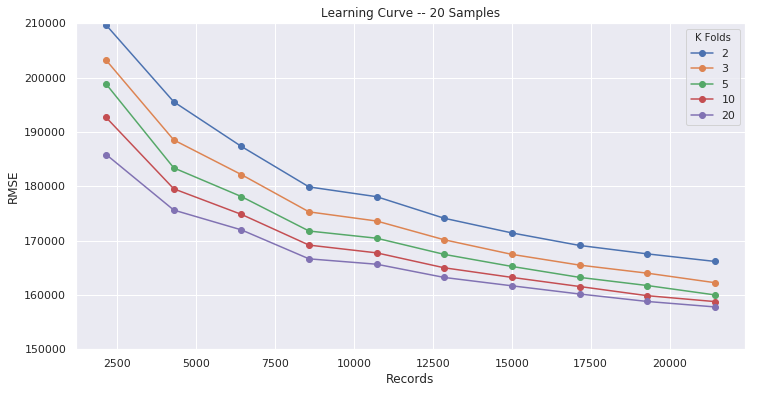

In [14]:
# plot RMSE vs Sample Size for various values of K
plt.figure(figsize=(12,6))

rmse_data = df.groupby(['k_fold','len'])['cv_score_mean'].mean()
for k in [2, 3, 5, 10, 20]:
    plt.plot(rmse_data.loc[k].index.values, -rmse_data.loc[k].values, marker='o', label=k)

plt.legend(title="K Folds")
plt.xlabel('Records')
plt.ylabel('RMSE')
plt.ylim(150000, 210000)
plt.title('Learning Curve -- 20 Samples')

### Learning Curve Analysis
Perhaps the first thing to note is that the general shape of the above Learning Curve is downward sloping and the shape is about the same regardless of the value of K.

For determining how much data is necessary, wherever the curve levels off, regardless of K, is good.  The Learning Curve appears to be leveling off at about the 90% mark, which is 19292 records.

K=20 provided the lowest RMSE score at every data set size.  Does this mean that we should choose K=20 to create a better model? The short answer is "no".

The RMSE scores that are plotted are estimates of the model's actual score.  These estimates have no affect on the model's true score.

The reason K=20 produces a lower estimated RMSE is that is has less pessimistic bias.  It has less pessimistic bias because it is using more of the data and the Learning Curve is not flat.

The difference between each learning curve, for a given dataset size, is the difference in bias due to having less data to train on.

### Sample Variance

The sample variance in the above plot was mitigated by using 10 different realizations of each subset of the full data.  This hides the variance of higher K values.  Below the same Learning Curve will be plotted using just 1 realization of each subset of data.

************
Because the bias drops with higher K, leave-one-out CV (the highest K possible) is sometimes used to get the least biased estimate of the model's performance.  However although it is least biased, it has the most variance, as seen below.

If K-Fold CV is being used for Model Selection, and the lowest CV score is used, the wrong model may be selected if the variance is too high!

In [15]:
# insted of taking the mean of the 10 values, just take the first value
dfg = df.groupby(['k_fold','len'])['cv_score_mean']
rmse_1 = dfg.apply(lambda x: x.iloc[0])
rmse_1.head(11)

k_fold  len  
2       2143    -207097.069434
        4287    -200135.328455
        6430    -192651.047403
        8574    -180214.675571
        10718   -179315.028110
        12861   -169198.126527
        15005   -171464.295399
        17148   -164729.064354
        19292   -168961.211156
        21436   -164708.429203
3       2143    -200804.516982
Name: cv_score_mean, dtype: float64

Text(0.5, 1.0, 'Learning Curve -- Single Subsample CV')

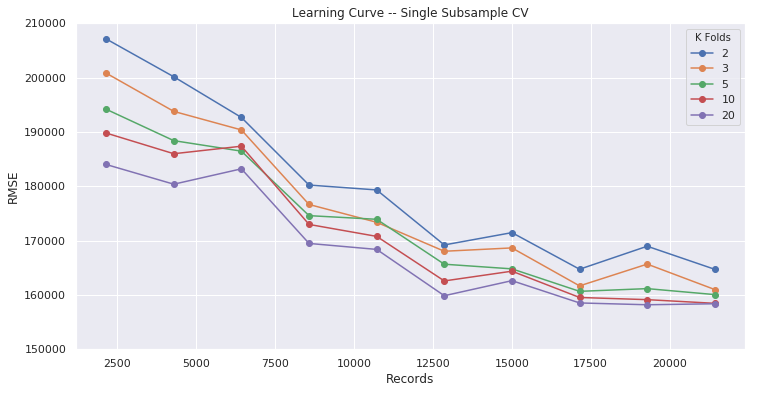

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client


In [16]:
# plot RMSE vs Sample Size for various values of K
plt.figure(figsize=(12,6))

for k in [2, 3, 5, 10, 20]:
    plt.plot(rmse_1.loc[k].index.values, -rmse_1.loc[k].values, marker='o', label=k)

plt.legend(title="K Folds")
plt.xlabel('Records')
plt.ylabel('RMSE')
plt.ylim(150000, 210000)
plt.title('Learning Curve -- Single Subsample CV')

The variance in the estimate of the model accuracy is too high to produce a meaningful Learning Curve.  This is what Repeated K-Fold CV was designed to help alleviate.

Run Repeated K-Fold CV on a one sample of data at each size.

In [17]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Compute Learning Curve Dask submit
start = time()

classifier = create_model()

r = []
repeated_cv = 20
for random_state in range(1):
    for frac in np.linspace(0.1, 1.0, 10):
        X_s, y_s = get_random_subsample(X_all.values, y_all.values, frac, random_state)
        for k_fold in [2, 3, 5, 10, 20]:
            r.append(client.submit(learning_curve4, classifier, X_s, y_s, k_fold, repeated_cv, random_state))

# gather the results from the scheduler
dfs_1_20 = client.gather(r)

print(f'Total Time: {time() - start}')

Total Time: 208.25377130508423


In [18]:
df = pd.concat(dfs_1_20, ignore_index=True)
df.head()

,k_fold,len,random_state,cv_score_mean,cv_score_std
0,2,2143,0,-199873.649839,16775.483131
1,3,2143,0,-193830.997769,18144.144960
2,5,2143,0,-188926.820629,24000.987040
3,10,2143,0,-183065.013739,34450.370113
4,20,2143,0,-179365.454593,46024.636550


Text(0.5,1,'Learning Curve -- Single Sample 20 Repeated CV')

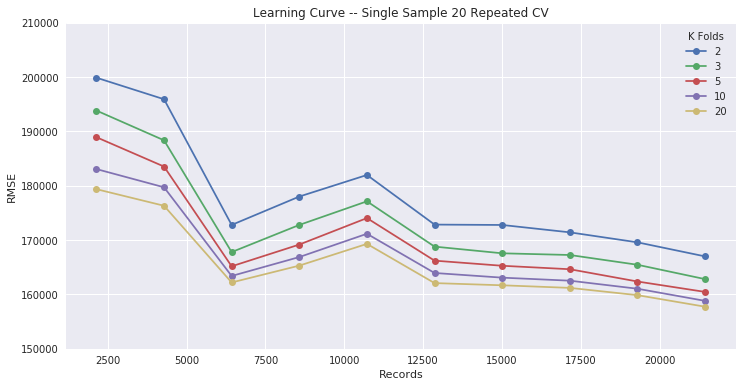

In [19]:
# plot RMSE vs Sample Size for various values of K
plt.figure(figsize=(12,6))

rmse_data = df.groupby(['k_fold','len'])['cv_score_mean'].mean()
for k in [2, 3, 5, 10, 20]:
    plt.plot(rmse_data.loc[k].index.values, -rmse_data.loc[k].values, marker='o', label=k)

plt.legend(title="K Folds")
plt.xlabel('Records')
plt.ylabel('RMSE')
plt.ylim(150000, 210000)
plt.title('Learning Curve -- Single Sample 20 Repeated CV')

Repeated K-Fold CV does not make up for sample variance (the variance due to which random sample was chosen).  There is less sample variance at higher percentages of the data.

At about 60% of the data (12681 records) and above, the Learning Curve looks reasonable.

Normally sample variance cannot be avoided as we only have one sample of the data.

In [10]:
def my_cv(B, size, random_state=None):
    if random_state:
        np.random.seed(random_state)
        
    cv = []
    for i in range(B):
        idx = np.random.choice(size, size=size, replace=True)
        idx_all = set(range(size))
        idx_validate = idx_all - set(idx)
        idx_validate = np.array(list(idx_validate))
        cv.append((idx, idx_validate))
    return cv

In [11]:
# Learning Curve5
def learning_curve5(classifier, X, y, B, random_state=None):
        
    # print(f'RandomState: {random_state} frac: {frac:3.1f} k_fold {k_fold}')
    
    # B bootstrap samples
    cv = my_cv(B, len(X_s), random_state)

    # compute the K cross validated scores
    # use n_jobs = 1 as this entire function will be parallelized
    scores = cross_val_score(classifier, X_s, y_s, cv=cv, n_jobs=1, scoring = rmse_scorer)

    return pd.DataFrame(data=[[X_s.shape[0], random_state, scores.mean(), 
                               scores.std(), B, scores]], 
                            columns=['len', 'random_state', 'cv_score_mean', 
                                     'cv_score_std', 'B', 'cv_scores'])

In [35]:
# Compute Learning Curve Dask ML
B = 100
classifier = create_model()
start = time()

# let Dask ML take care of cross_val_score()
dfs_bs = []
for random_state in range(6):
    for frac in np.linspace(0.1, 1.0, 10):
        X_s, y_s = get_random_subsample(X_all.values, y_all.values, frac, random_state)
        dfs_bs.append(client.submit(learning_curve5, classifier, X_s, y_s, B, random_state))
    
dfs_bs = client.gather(dfs_bs)    

print(f'Total Time: {time() - start}')

Total Time: 325.0809259414673


In [36]:
dfs_bs = client.gather(dfs_bs)

In [37]:
df_bs = pd.concat(dfs_bs, ignore_index=True)
df_bs.head()

,len,random_state,cv_score_mean,cv_score_std,B,cv_scores
0,2143,0,-210774.839771,37057.227827,100,"[-184549.43928290697, -181919.15553324486, -17..."
1,4287,0,-167904.403405,9520.035836,100,"[-170911.38989946723, -164391.20294388552, -16..."
2,6430,0,-175529.302284,9306.907750,100,"[-179049.89735734943, -170557.5403070834, -190..."
3,8574,0,-179669.078405,11074.296196,100,"[-175256.2876781497, -165902.4326467318, -1778..."
4,10718,0,-164086.343367,7407.935264,100,"[-157866.14365690446, -154496.93504985556, -15..."


In [38]:
# messy code to get a numpy array from an element in a dataframe
from collections import defaultdict
scores = defaultdict(list)
for key, group in df_bs.groupby(['len','random_state'])['cv_scores']:
    scores[key[0]].extend(group.values[0])

In [72]:
x=[]
y=[]
for key in scores.keys():
    x.append(key)
    y.append(-np.array(scores[key]).mean())
    print(f'{key: 6d} {-np.array(scores[key]).mean(): 9.1f}')

  2143  226133.3
  4287  196762.0
  6430  189889.9
  8574  182383.0
 10718  176626.5
 12861  174072.5
 15005  172295.7
 17148  170546.6
 19292  168475.9
 21436  167041.9


In [73]:
y

[226133.30638742656,
 196761.98509473537,
 189889.87173268807,
 182383.01126727974,
 176626.51941367268,
 174072.48852175084,
 172295.6660442696,
 170546.57582482466,
 168475.93262509166,
 167041.92372189194]

In [12]:
# Compute Learning Curve Dask ML

random_state = 1
B = 600
classifier = create_model()
start = time()

# let Dask ML take care of cross_val_score()
dfs_bs = []
with parallel_backend('dask.distributed', scheduler_host='atlantis:8786'):
    for frac in np.linspace(0.1, 1.0, 10):
        X_s, y_s = get_random_subsample(X_all.values, y_all.values, frac, random_state)
        dfs_bs.append(learning_curve5(classifier, X_s, y_s, B, random_state))

print(f'Total Time: {time() - start}')

Total Time: 336.8523688316345


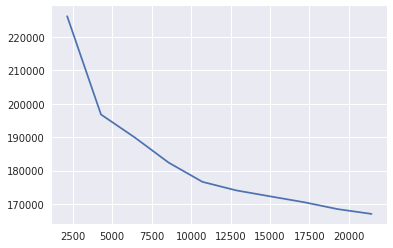

In [64]:
plt.plot(x,y)

Text(0.5,1,'Learning Curve -- Bootstrap 600 Replicas 1 Sample')

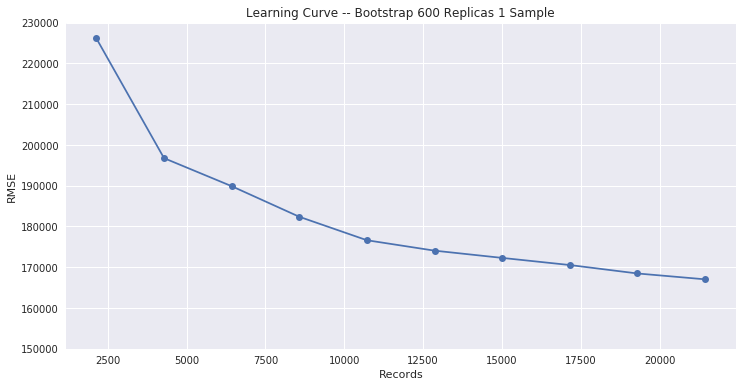

In [67]:
# plot RMSE vs Sample Size for various values of K
plt.figure(figsize=(12,6))

plt.plot(x,y, marker='o', label='600-bs')
# plt.plot(rmse_data.loc[2].index.values, -rmse_data.loc[2].values, marker='o', label='20CV2')

# plt.legend(title="Bootstrap")
plt.xlabel('Records')
plt.ylabel('RMSE')
plt.ylim(150000, 230000)
# plt.legend()
plt.title('Learning Curve -- Bootstrap 600 Replicas 1 Sample')

In [23]:
df_bs = pd.concat(dfs_bs, ignore_index=True)

Text(0.5,1,'Learning Curve -- Bootstrap 600 Replicas 1 Sample')

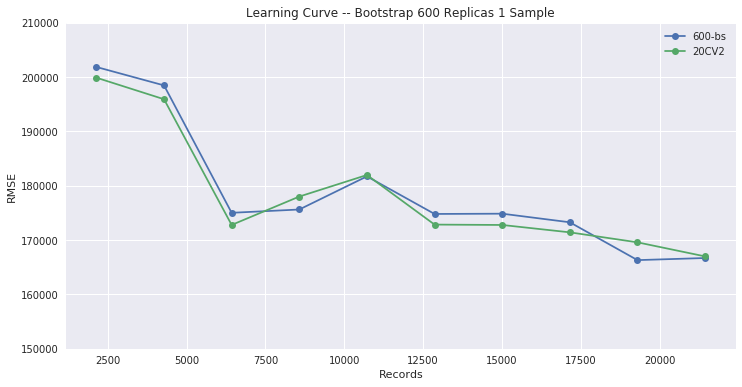

In [36]:
# plot RMSE vs Sample Size for various values of K
plt.figure(figsize=(12,6))

plt.plot(df_bs['len'], -df_bs['cv_score_mean'], marker='o', label='600-bs')
plt.plot(rmse_data.loc[2].index.values, -rmse_data.loc[2].values, marker='o', label='20CV2')

# plt.legend(title="Bootstrap")
plt.xlabel('Records')
plt.ylabel('RMSE')
plt.ylim(150000, 210000)
plt.legend()
plt.title('Learning Curve -- Bootstrap 600 Replicas 1 Sample')

As more data becomes available, the model has more data to train on so the model is more stable, and the model has more data to be validate against, so the validation is more stable, hence the standard deviation of the RMSE goes down.

For a given dataset size, as K becomes lower, more data is available for validation.  With more data available for validation, the sample variance of the validation set goes down, allowing for a more stable estimate of the model's score.

### Which Value of K is "Best"
The Bias-Variance tradeoff means that for a more accurate estimate of the model's performance, the higher the variance of that estimate.  As such, there is no "best" value.

For the above model, it might be argued that K=5 results in a good tradeoff of bias vs variance.

### Bootstrap Estimate
The bootstrap estimate of the model's score is not often used as the result is similar to 2-Fold CV but requires more computation.  The bootstrap replica for training contains about 62.8% unique records and the bootstrap replica for testing is the 37.2% of the records not in training.

Scikit Learn does not have a bootstrap cross validation generator, but it is easy to create one.

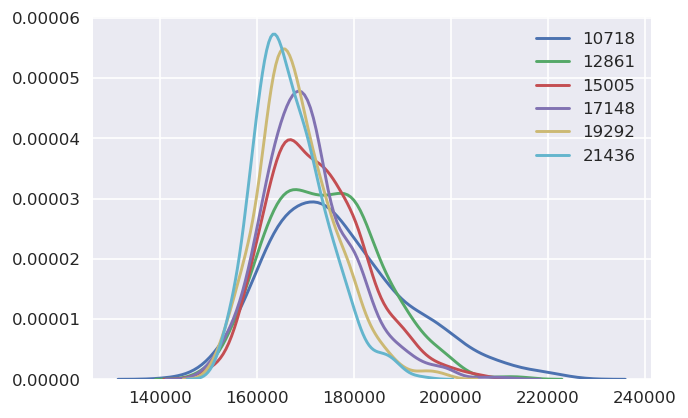

In [114]:
from scipy import stats
plt.figure(figsize=(6,4), dpi=120)

# stats.boxcox()
             
for key in scores.keys():
    if key > 10000:
        sns.distplot(-np.array(scores[key]),hist=False, label=key)
plt.legend()

In [ ]:
t = -np.array(scores[12861])

In [122]:
%%R
library(boot)

bs_mean <- function(data, indices) {
  d <- data[indices] # allows boot to select sample 
  return(mean(d))
}

set.seed(108)
r_boot_ci <- function(x, t, bs_all_stat) {
  results <- NULL
  results$data <- x
  results$t <- t
  results$t0 <- bs_all_stat
  
  results$R <- length(t)  
  results$strata <- rep(1,length(x))
  results$weights <- rep(1.0/length(x), length(x))
    
  results$sim <- 'ordinary'
  results$statistic <- NULL
  results$call <- NULL
  results$stype <- 'i'
  results$seed <- get(".Random.seed", envir = .GlobalEnv, inherits = FALSE)
  
  boot.ci(results)
}

In [118]:
%load_ext rpy2.ipython

import pandas as pd
df = pd.DataFrame({
    'cups_of_coffee': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'productivity': [2, 5, 6, 8, 9, 8, 0, 1, 0, -1]
})

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


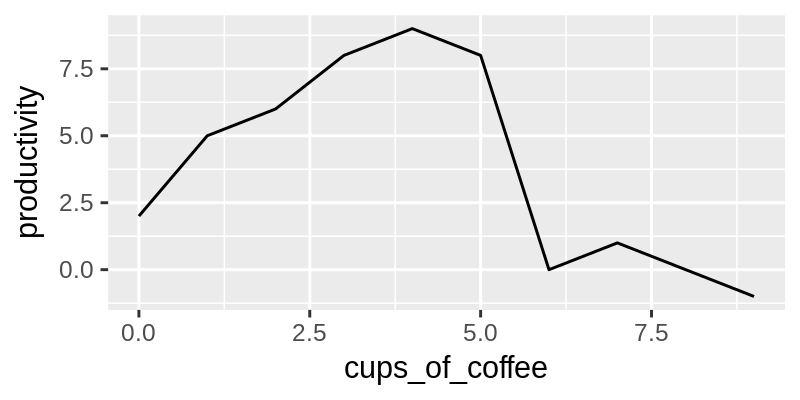

In [120]:
%%R -i df -w 4 -h 2 --units in -r 200
library(ggplot2)
ggplot(df, aes(x=cups_of_coffee, y=productivity)) + geom_line()

In [154]:
X = X_all.values
y = y_all.values

In [163]:
%%R -i X -i y
library(MASS)
print(dim(X))
print(y[20])
print(typeof(y))
boxcox(y)

[1] 21436    16
[1] 230000
[1] "double"
Error in object$y : $ operator is invalid for atomic vectors


In [140]:
from scipy.stats import boxcox
boxcox(y_all.values)
y_all.values.shape[0]

/home/agni/anaconda3/envs/anaconda/lib/python3.6/site-packages/scipy/stats/morestats.py:900: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/home/agni/anaconda3/envs/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/home/agni/anaconda3/envs/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1929: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
/home/agni/anaconda3/envs/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/agni/anaconda3/envs/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1926: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)


21436

In [136]:
y_mean = y_all.mean()
y = y_all
N = len(y_all)
np.log(np.sum((y - y_mean)**2. / N, axis=0))

25.62849010636556

In [134]:
y_all.describe()/1e4

count      2.143600
mean      54.108944
std       36.742275
min        7.500000
25%       32.330000
50%       45.000000
75%       64.500000
max      770.000000
Name: price_mean, dtype: float64

In [131]:
y_all.max()

7700000.0

In [132]:
y_all.mean()

541089.4383513716

/home/agni/anaconda3/envs/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


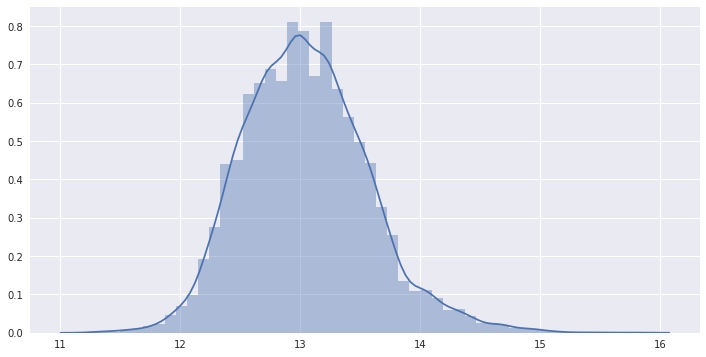

In [166]:
plt.figure(figsize=(12,6))
sns.distplot(np.log(y))